<a href="https://colab.research.google.com/github/AlenaAntipina/PytorchLearning/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импортируем нужные библиотеки

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import zipfile
import os

Подключим гугл-диск и распакуем датасет

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!cp /content/gdrive/MyDrive/Classificator/observations-master.zip ../

In [ ]:
!unzip ../observations-master.zip -d data/

In [20]:
data_dir = '/content/data/observations-master/experiements/data'

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
import matplotlib.pyplot as plt

In [10]:
import pathlib
from pathlib import Path
import os

import natsort

import cv2
from PIL import Image

Выведем часть фотографий на экран и сравним их размеры и формат

In [14]:
without_mask_filenames = os.listdir('/content/data/observations-master/experiements/data/without_mask')
without_mask_filenames = natsort.natsorted(without_mask_filenames)

with_mask_filenames = os.listdir('/content/data/observations-master/experiements/data/with_mask')
with_mask_filenames = natsort.natsorted(with_mask_filenames)

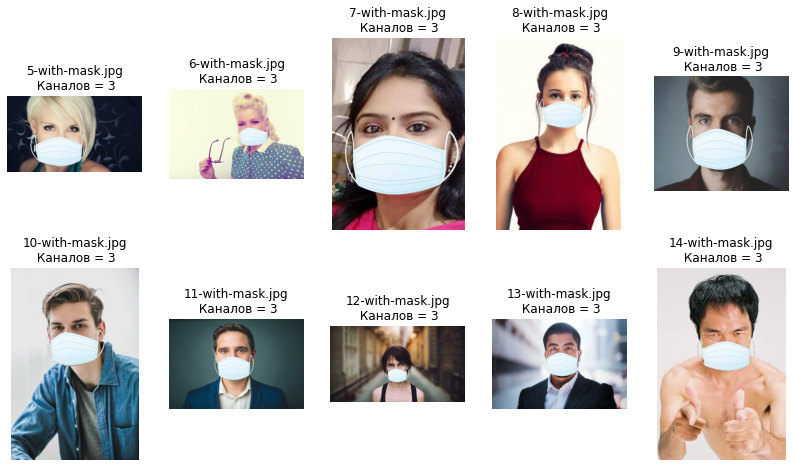

In [15]:
pic_box = plt.figure(figsize=(14,12))
for i, image_name in enumerate(with_mask_filenames[5:15]):
  image = plt.imread(str(Path('/content/data/observations-master/experiements/data/with_mask', image_name)))
  ax = pic_box.add_subplot(3,5,i+1)
  ax.set_title(str(image_name) + '\n Каналов = ' + str(image.shape[2]))
  plt.imshow(image)
  plt.axis('off')
plt.show()

Конвертируем трехканальные фотографии в четырехканальные

In [17]:
for img in with_mask_filenames:
  im = Image.open(Path('/content/data/observations-master/experiements/data/with_mask', img))
  if (img[-3:].lower()=='png' and im.format is 'PNG'):
    if (im.mode is not 'RGBA'):
      im.convert("RGBA").save(Path('data/dataset/images/with_mask', img))
      print(img)

In [18]:
for img in without_mask_filenames:
  im = Image.open(Path('/content/data/observations-master/experiements/data/without_mask', img))
  if (img[-3:].lower()=='png' and im.format is 'PNG'):
    if (im.mode is not 'RGBA'):
      im.convert("RGBA").save(Path('data/dataset/images/without_mask', img))
      print(img)

Разделим датасет: 80% - тренировочный, 20% валидационный

In [21]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1376 files belonging to 2 classes.
Using 1101 files for training.


In [22]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1376 files belonging to 2 classes.
Using 275 files for validation.


In [23]:
class_names = train_ds.class_names
print(class_names)

['with_mask', 'without_mask']


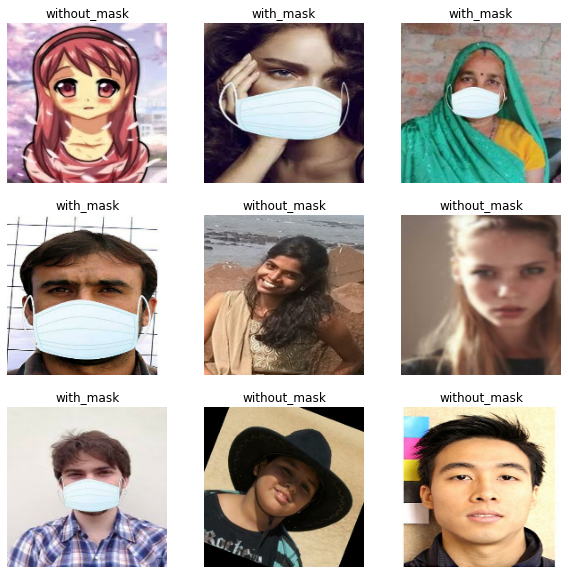

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
num_classes = len(class_names)

Увеличим количество данных с помощью генерирования новых данных за счет незначительных преобразований уже имеющихся фотографий

In [27]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

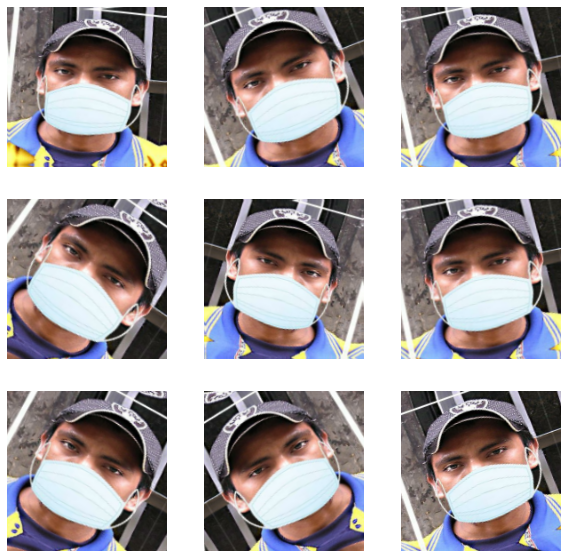

In [28]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Построение модели

In [29]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [30]:
checkpoint_filepath = 'best_model.h5'

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True)

In [31]:
epochs = 10

In [32]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
35/35 [==============================] - 11s 65ms/step - loss: 0.5597 - accuracy: 0.7657 - val_loss: 0.2255 - val_accuracy: 0.8982
Epoch 2/10
35/35 [==============================] - 1s 40ms/step - loss: 0.1821 - accuracy: 0.9346 - val_loss: 0.1561 - val_accuracy: 0.9273
Epoch 3/10
35/35 [==============================] - 1s 39ms/step - loss: 0.1132 - accuracy: 0.9591 - val_loss: 0.1011 - val_accuracy: 0.9564
Epoch 4/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0808 - accuracy: 0.9728 - val_loss: 0.0794 - val_accuracy: 0.9673
Epoch 5/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0585 - accuracy: 0.9827 - val_loss: 0.1153 - val_accuracy: 0.9636
Epoch 6/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0620 - accuracy: 0.9764 - val_loss: 0.0887 - val_accuracy: 0.9673
Epoch 7/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0443 - accuracy: 0.9855 - val_loss: 0.0855 - val_accuracy: 0.9673
Epoch 8/10
3

Несколько графиков для визуализации результатов обучения

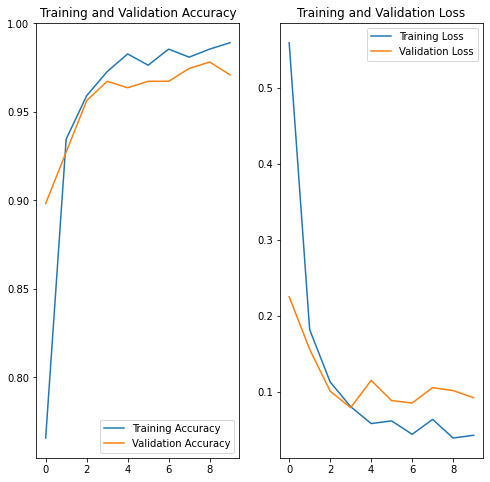

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Проверим на сторонних изображениях

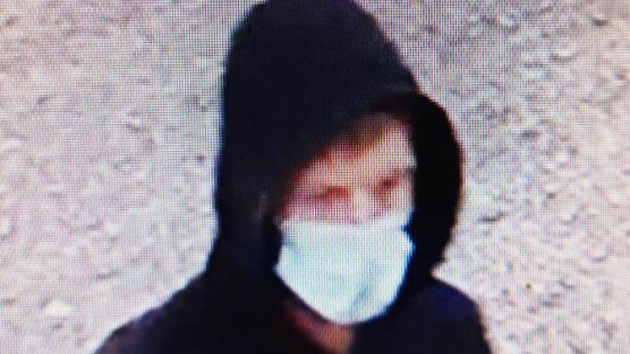

In [43]:
img = tf.keras.utils.load_img(
    '/content/gdrive/MyDrive/Classificator/with1.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 16ms/step
This image most likely belongs to with_mask with a 79.19 percent confidence.
